<a href="https://colab.research.google.com/github/LBMH-lang/Nh-m_11_KNN/blob/main/KNN_fruit_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Thư viện và Dataset


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from random import shuffle
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
IMG = cv2.imread("/content/drive/MyDrive/fruit_data/image/Apple/0_100.jpg")
#chuyển đổi không gian màu của ảnh từ BGR (Blue-Green-Red) sang RGB (Red-Green-Blue)
rgb_image = cv2.cvtColor(IMG, cv2.COLOR_BGR2RGB)

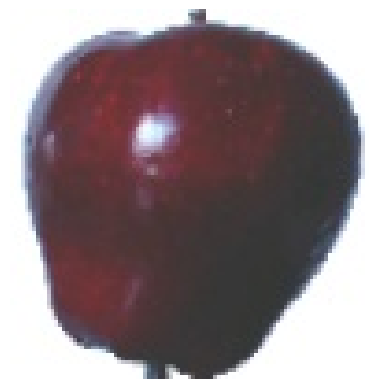

In [4]:
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

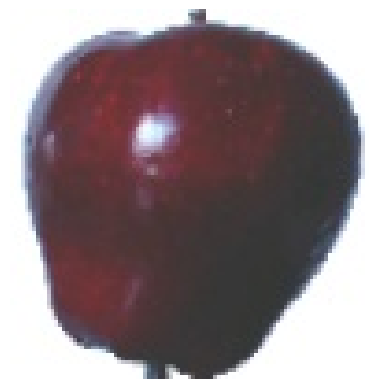

In [5]:
rop = cv2.resize(rgb_image,(100,100))
plt.imshow(rop)
plt.axis('off')
plt.show()

<Axes: >

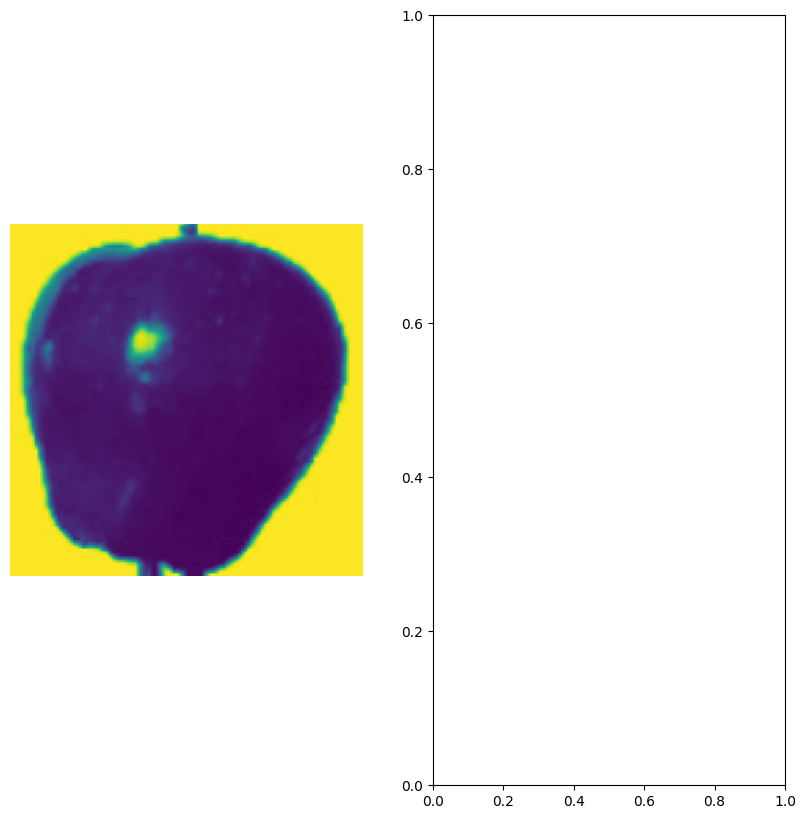

In [6]:
image_size = 128
path = "/content/drive/MyDrive/fruit_data/image/Apple/0_100.jpg"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (image_size, image_size)).flatten()
np_img=np.asarray(img)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(np_img.reshape(image_size, image_size))
plt.axis('off')
plt.subplot(1, 2, 2)

In [7]:
fruits=pd.read_table('/content/drive/MyDrive/fruit_data/FRUITS_DATA.txt')

Sau khi đã Load được dataset, ta kiểm tra 5 dòng đầu của dữ liệu như thế nào

In [8]:
fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,1,apple,braeburn,178,7.1,7.8,0.92
4,1,apple,braeburn,172,7.4,7.0,0.89


In [9]:
# Chuyển từ giá trị nhãn trái cây sang tên trái cây để giúp diễn giải kết quả dễ dàng hơn
predct = dict(zip(fruits.fruit_label.unique(), fruits.fruit_name.unique()))
predct

{1: 'apple', 3: 'orange', 4: 'lemon'}

Bộ dữ liệu có bảy cột chứa thông tin về trái cây. Mỗi quả được mô tả với bốn đặc điểm, tức là 1) khối lượng quả 2) chiều rộng của quả 3) chiều cao và 4) điểm màu của quả là gì. Bây giờ chúng ta phải kiểm tra xem có bao nhiêu loại trái cây có trong dữ liệu.

In [10]:
fruits['fruit_name'].value_counts()

apple     19
orange    19
lemon     16
Name: fruit_name, dtype: int64

Chúng ta thấy rằng dataset chứa ba loại trái cây. Táo có 19 mục, cam có 19 mục, chanh có 16 mục.

Bây giờ ta sẽ lưu trữ tất cả dữ liệu trên ba khung dữ liệu khác nhau.

In [11]:
apple_data=fruits[fruits['fruit_name']=='apple']
orange_data=fruits[fruits['fruit_name']=='orange']
lemon_data=fruits[fruits['fruit_name']=='lemon']


In [12]:
apple_data.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,1,apple,braeburn,178,7.1,7.8,0.92
4,1,apple,braeburn,172,7.4,7.0,0.89


In [13]:
orange_data.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
19,3,orange,spanish_jumbo,342,9.0,9.4,0.75
20,3,orange,spanish_jumbo,356,9.2,9.2,0.75
21,3,orange,spanish_jumbo,362,9.6,9.2,0.74
22,3,orange,selected_seconds,204,7.5,9.2,0.77
23,3,orange,selected_seconds,140,6.7,7.1,0.72


In [14]:
lemon_data.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
38,4,lemon,spanish_belsan,194,7.2,10.3,0.70
39,4,lemon,spanish_belsan,200,7.3,10.5,0.72
40,4,lemon,spanish_belsan,186,7.2,9.2,0.72
41,4,lemon,spanish_belsan,216,7.3,10.2,0.71
42,4,lemon,spanish_belsan,196,7.3,9.7,0.72


Bằng cách xem xét dữ liệu trên, ta thấy rằng đối với mỗi loại trái cây đều có một nhãn_quả. Đối với táo là 1, đối với cam là 3 và đối với chanh là 4. Bây giờ ta sẽ trực quan hóa dữ liệu này trên các plot để khám phá thêm.

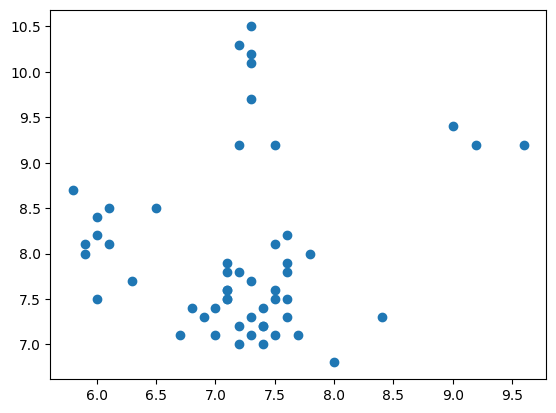

In [15]:
plt.scatter(fruits['width'],fruits['height'])

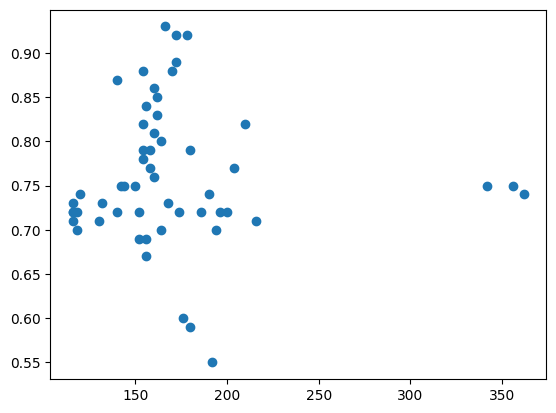

In [16]:
plt.scatter(fruits['mass'],fruits['color_score'])

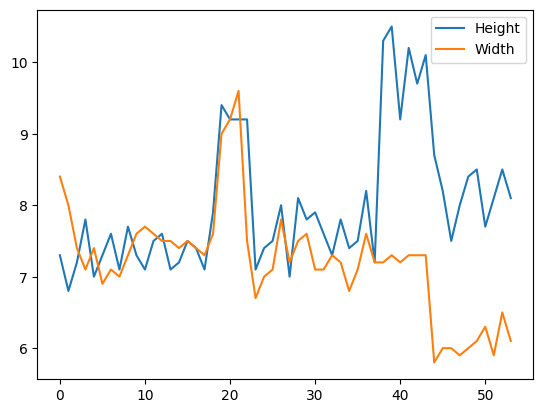

In [17]:
plt.plot(fruits['height'],label='Height')
plt.plot(fruits['width'],label='Width')
plt.legend()

Bây giờ chúng ta sẽ sử dụng bộ phân loại K-Nearest Neighbors để dự đoán một bản ghi mới trên cơ sở dữ liệu này. Để làm điều này, chúng ta sẽ chia tập dữ liệu này thành tập test và tập train. Đầu tiên chúng ta sẽ nhập thư viện sklearn cho mô hình của mình.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [19]:
X=fruits[['mass','width','height']]
Y=fruits['fruit_label']
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=0)

In [20]:
X_train.describe()

,mass,width,height
count,40.000000,40.00000,40.000000
mean,173.200000,7.24000,8.012500
std,56.974668,0.81612,1.004653
min,116.000000,5.80000,6.800000
25%,150.000000,6.97500,7.300000
50%,161.000000,7.20000,7.600000
75%,178.500000,7.50000,8.500000
max,362.000000,9.60000,10.500000


In [21]:
X_test.describe()

,mass,width,height
count,14.000000,14.000000,14.000000
mean,163.571429,7.135714,7.964286
std,29.468926,0.625862,0.773212
min,118.000000,6.000000,7.000000
25%,151.000000,7.125000,7.350000
50%,157.000000,7.350000,7.950000
75%,186.500000,7.500000,8.175000
max,210.000000,7.800000,9.700000


Bây giờ ta sẽ tạo một bộ phân loại KNN để đưa ra dự đoán.

In [22]:
knn=KNeighborsClassifier()

In [23]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

Kiểm tra tính chính xác của bộ phân loại

In [24]:
knn.score(X_test,y_test)

0.42857142857142855

Bây giờ chúng ta đưa ra dự đoán với dữ liệu mới như sau:

In [25]:
prediction1=knn.predict([[100,6,8]])
predct[prediction1[0]]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


'lemon'

In [26]:
prediction2=knn.predict([[300,7,10]])
predct[prediction2[0]]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


'orange'